In [1]:
from pathlib import Path

from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns

import searchnets

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

paths

In [3]:
SOURCE_DATA_ROOT = pyprojroot.here('results/searchstims/source_data/')

FIGURES_ROOT = pyprojroot.here('docs/paper/figures/experiment-1')

constants

In [4]:
LEARNING_RATE = 1e-3

NET_NAMES = [
    'VGG16'
]

STIM_TYPES = [
    'RVvGV',
    'RVvRHGV',
    '2_v_5',
]

SET_SIZES = [
    1,
    2,
    4,
    8,
]

## load / tidy source data

In [5]:
df_all = []    

TODO = (
    ('3stims', 'transfer' , 'Train on natural images, adapt to visual search task'),
    ('3stims_CelebASpoof', 'transfer', 'Train on faces, adapt to visual search task'),
    ('3stims_nih_chest_xray', 'transfer', 'Train on x-ray images, adapt to visual search task'),
    ('3stims', 'initialize', 'Train only on visual search task'),
    ('10stims', 'initialize', 'Train only on visual search task (10 stimulus types)'),
    ('3stims_big_set_size', 'initialize', 'Train only on visual search task (7 set sizes)'),
)

for source_data_dir, method, label in TODO:
    df = pd.read_csv(SOURCE_DATA_ROOT / source_data_dir / 'all.csv')

    df = df[
        (df.net_name.isin(NET_NAMES)) &
        (df.method == method) &
        (df.stimulus.isin(STIM_TYPES)) *
        (df.set_size.isin(SET_SIZES))
    ]
    df['label'] = label
    df_all.append(df)

df_all = pd.concat(df_all)

df_all = df_all[df_all.target_condition == 'both']

# map set sizes to consecutive integers
set_size_uniq = df_all.set_size.unique()
set_size_map = dict(zip(set_size_uniq, range(len(set_size_uniq))))
df_all['set_size_int'] = df_all.set_size.map(set_size_map)
df_all.accuracy = df_all.accuracy * 100

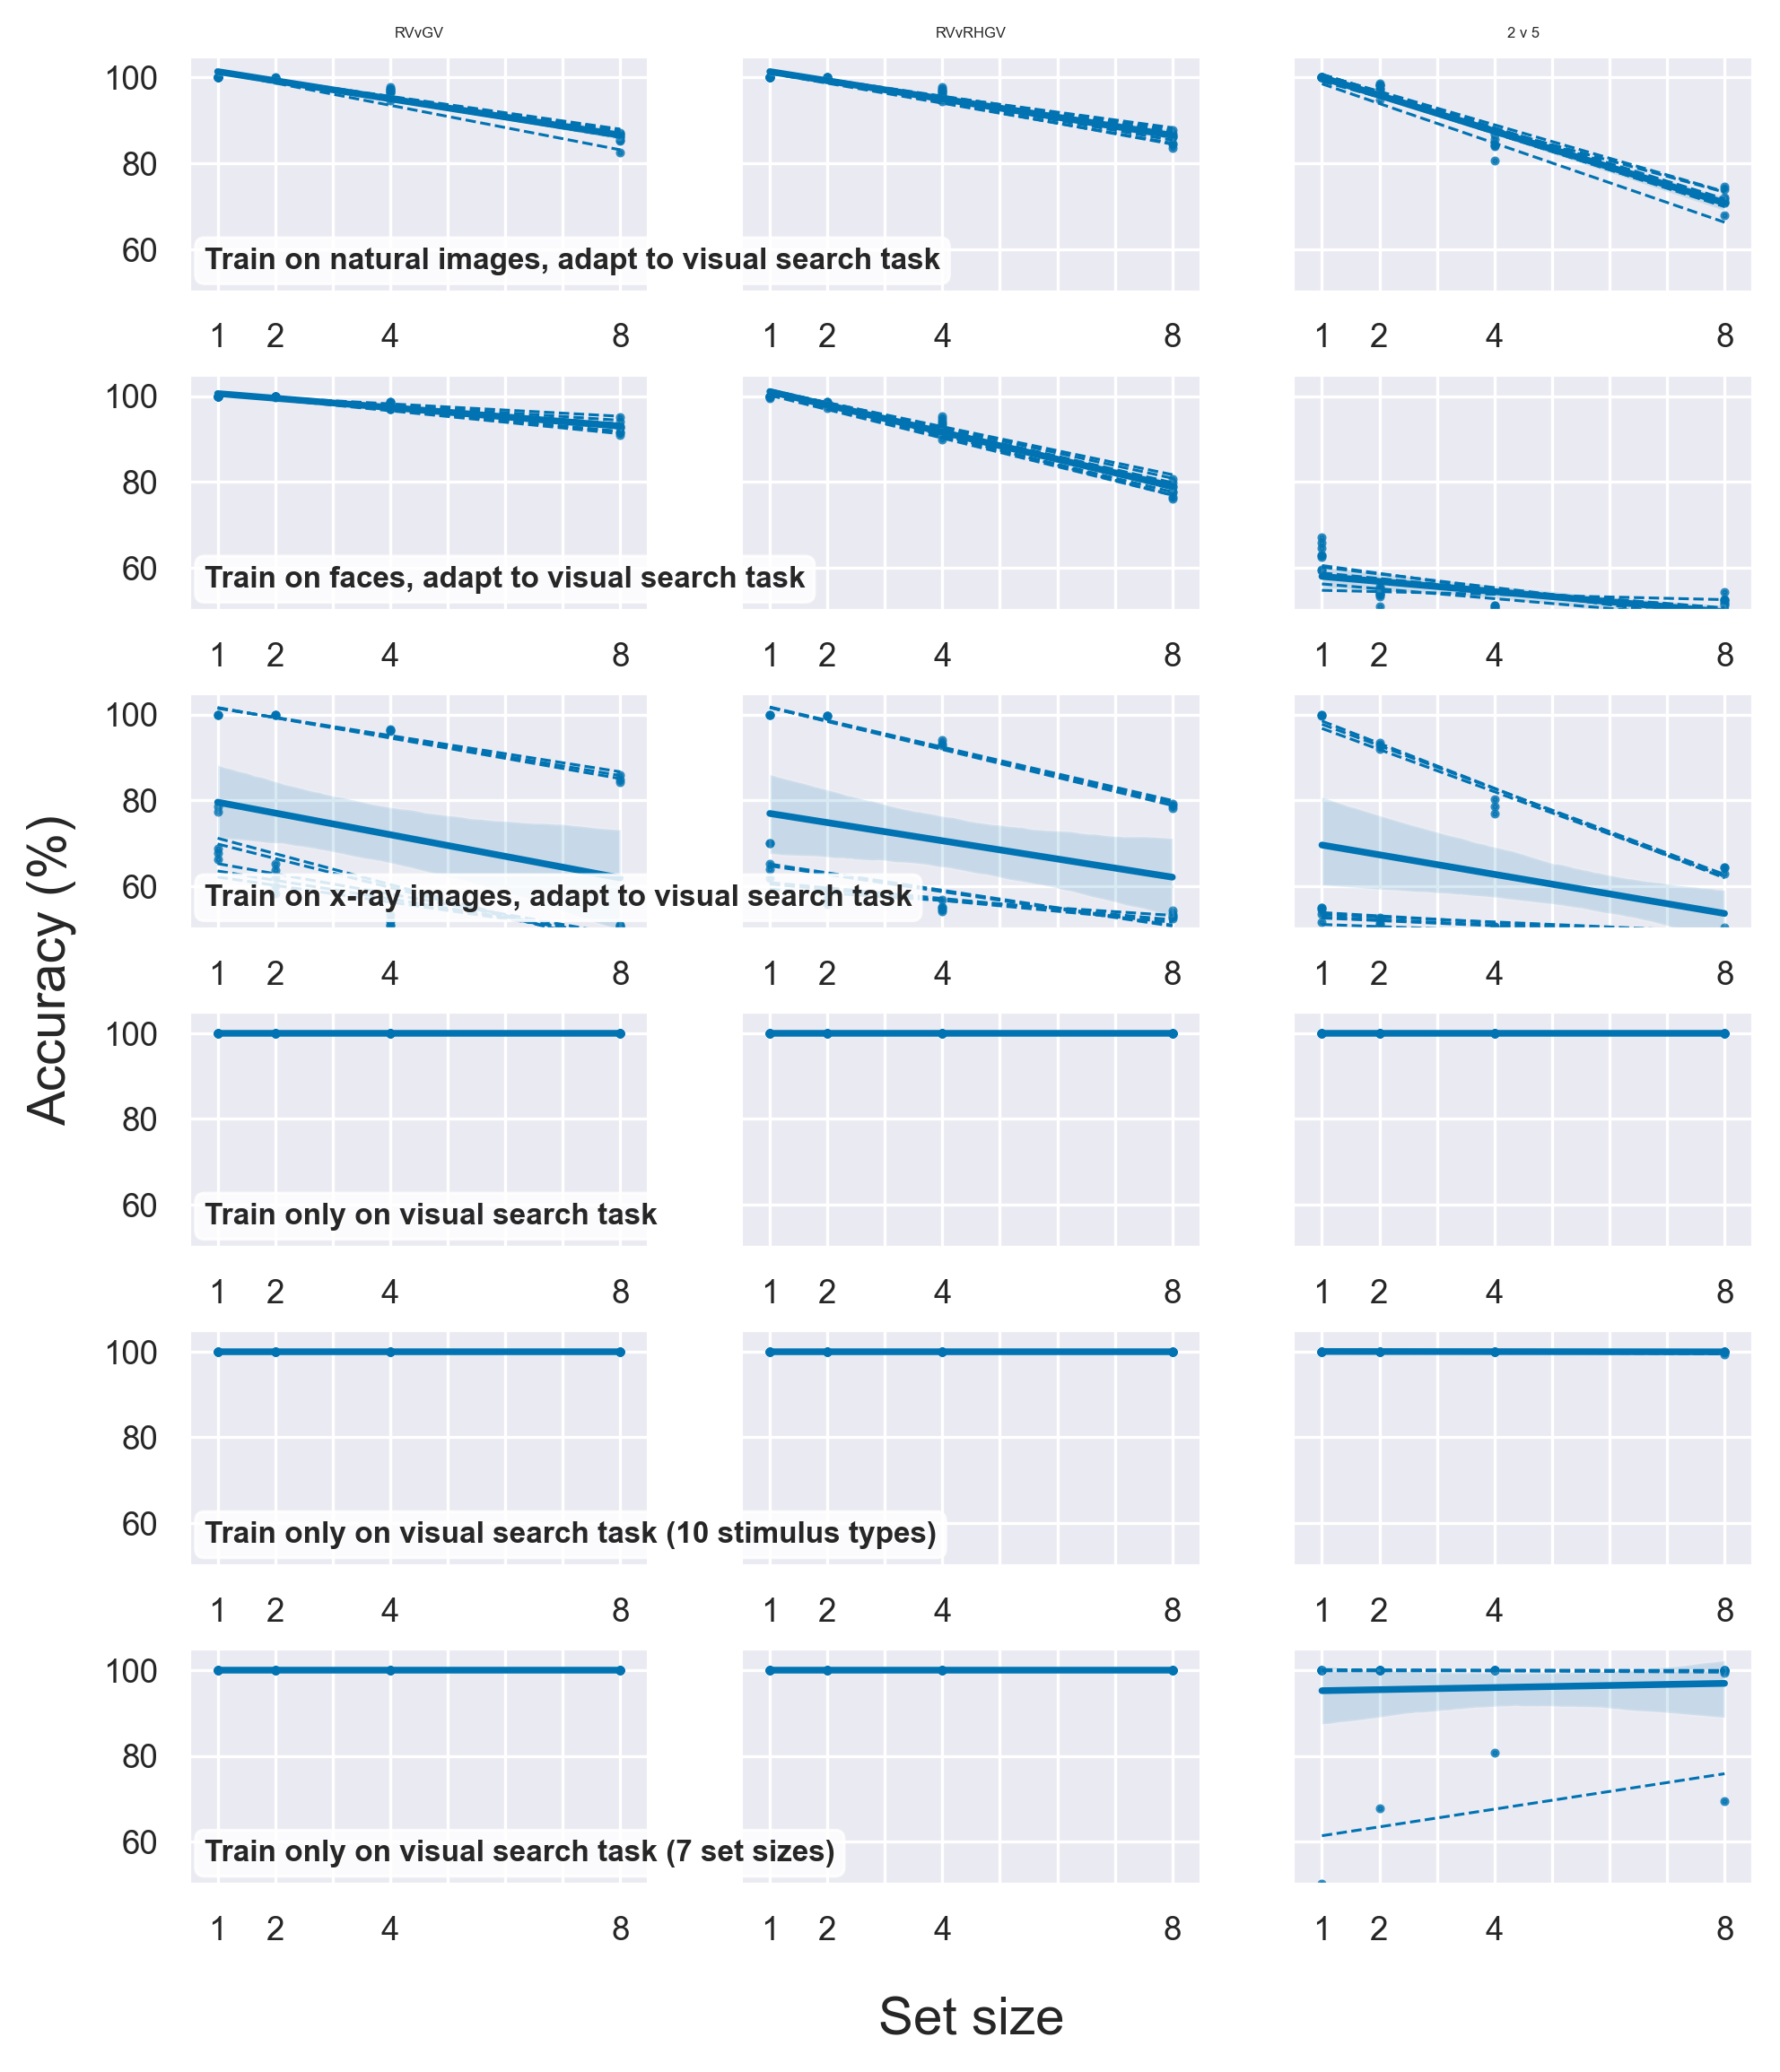

In [6]:
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('colorblind')

FIGSIZE = (7.5, 9)
DPI = 300

FIG_ROWS = df_all.label.unique()
FIG_COLUMNS = df_all.stimulus.unique()

n_rows = len(FIG_ROWS)
n_cols = len(FIG_COLUMNS)
fig, ax_arr = plt.subplots(n_rows, n_cols, sharey=True, figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(hspace=0.35)

row_axes = []
for row in range(n_rows):
    row_ax = fig.add_subplot(n_rows, 1, row + 1)
    row_ax.set_xticks([])
    row_ax.set_yticks([])
    row_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    row_ax.grid(False)
    row_ax.patch.set_facecolor('none')
    row_axes.append(row_ax)

TEXTBOX_PROPS = dict(boxstyle='round', facecolor='white', alpha=0.85)

STIM_FONTSIZE = 4

add_legend = False

NET_NAME = 'VGG16'

line_color = sns.color_palette()[0]

for row, label in enumerate(FIG_ROWS):
    df_this_label = df_all[df_all['label'] == label]
    method = df_this_label.method.unique()[0]

    for col, stim_name in enumerate(FIG_COLUMNS):

        df_this_label_this_stim = df_this_label[df_this_label.stimulus == stim_name]

        ax = ax_arr[row, col]
        ax.set_axisbelow(True)  # so grid is behind

        data = df_this_label[
            (df_this_label.net_name == NET_NAME) &
            (df_this_label.stimulus == stim_name)
        ]
        
        sns.regplot(
            data=data,
            x='set_size',
            y='accuracy',
            x_ci='sd',
            ax=ax,
            scatter=True,
            scatter_kws={'s': 2}
        )

        for net_number in data.net_number.unique():
            data_net = data[data.net_number == net_number]
            sns.regplot(
                data=data_net,
                x='set_size',
                y='accuracy',
                ci=None,
                scatter=False,
                ax=ax,
                line_kws={'linewidth': 0.75, 'linestyle': 'dashed', 'color': line_color}
            )

        ax.set_xticks(range(1, 9))
        ax.set_xticklabels(range(1, 9))
        for ticklabel in ax.xaxis.get_ticklabels():
            pos0 = ticklabel.get_position()[0]
            if pos0 not in SET_SIZES:
                ticklabel.set_visible(False)
        ax.set_xlim([0.5, 8.5])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_ylim([50, 105])
        ax.set_yticks([60, 80, 100])

        if row == 0:
            title = stim_name.replace('_',' ')
            ax.set_title(title, 
                         fontsize=STIM_FONTSIZE,
                         pad=5)  # pad so we can put image over title without it showing
        if col == 0:
            row_axes[row].text(0.01, 0.1, label, fontsize=8, weight='bold', bbox=TEXTBOX_PROPS)

# add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

LEGEND_FONTSIZE = 5

if '3stims' in str(FIGURES_ROOT):
    BBOX_TO_ANCHOR = (1.55, 0.85)
elif '10stims' in str(FIGURES_ROOT):
    BBOX_TO_ANCHOR = (0.005, 0.55, 0.4, .075)


big_ax.set_xlabel("Set size", labelpad=30, fontsize=14);
big_ax.set_ylabel('Accuracy (%)', labelpad=30, fontsize=14);

for ext in ('svg', 'png'):
    fig_path = FIGURES_ROOT.joinpath(
        f'acc-v-set-size-VGG16-transfer-v-initialize.{ext}'
    )
    plt.savefig(fig_path, bbox_inches="tight")